In [1]:
from model_utils import configuration as cnf
from analysis import restore_plots
from model_utils import initialisation as init
from sectors import electricity
from sectors import trade
from sectors import extraction
from sectors import storage
from sectors import enertransp

In [2]:
model = init.init_model()
trade.configure_sector(model)
electricity.configure_sector(model)
extraction.configure_sector(model)
storage.configure_sector(model)
enertransp.configure_sector(model)

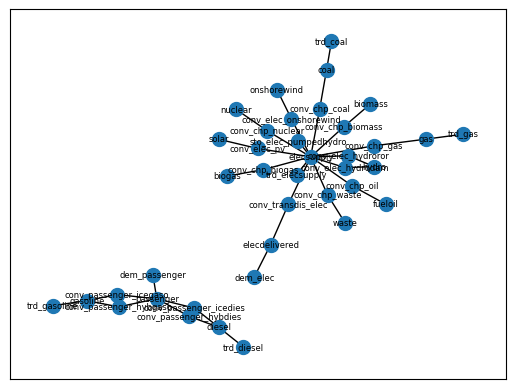

In [7]:
# Show network complexity
restore_plots.plot_io_network(cnf.DATA.fxe["FiE"], cnf.DATA.fxe["FoE"])